In [50]:
import gym
from gym import wrappers
import matplotlib.pyplot as plt

def play(num_episodes, num_steps, policy, update=None, preprocess = None, num_obs=1):
    time_steps = []
    for i_episode in range(num_episodes):
        observation = env.reset()
        states, actions, rewards = [], [], []
        observations = []
        r = 0
        for t in range(num_steps):
            #env.render()
            #observation = np.concatenate((np.array([observation[0]]),observation[1]))
            
            states.append(observation)
            
            if len(states) < num_obs:
                action = env.action_space.sample()
            else:
                obs = states[-num_obs:]
                
                if preprocess is not None:
                    for i in range(num_obs):
                        obs[i] = preprocess(obs[i])
                
                observations.append(np.array(obs))
                action = policy(np.array(obs))

            observation, reward, done, info = env.step(action)
            r += reward
            
            actions.append(action)
            rewards.append(reward)
                
            if done:
                break
        
        if update:
            update(actions[num_obs-1:], observations, rewards[num_obs-1:])
        
        time_steps.append(t)

    #env.close()
    #w, b = best_params
    return time_steps, r

In [2]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline


def downsample(image):
    # Take only alternate pixels - basically halves the resolution of the image (which is fine for us)
    return image[::2, ::2, :]

def remove_color(image):
    """Convert all color (RGB is the third dimension in the image)"""
    return image[:, :, 0]

def remove_background(image):
    image[image == 144] = 0
    image[image == 109] = 0
    return image

def preprocess_observations(input_observation):
    """ convert the 210x160x3 uint8 frame into a 6400 float vector """
    processed_observation = input_observation[35:195] # crop
    processed_observation = downsample(processed_observation)
    processed_observation = remove_color(processed_observation)
    processed_observation = remove_background(processed_observation)
    processed_observation[processed_observation != 0] = 1 # everything else (paddles, ball) just set to 1
    
    return processed_observation.reshape(80, 80, 1)

def generate_observation(observation1, observation2, observation3, observation4):
    return np.dstack((observation1, observation2, observation3, observation4))


[2017-06-08 11:36:37,940] Making new env: Pong-v0


-20.0 -20.4961935982
-20.4961935982 -20.0
-19.0 -20.4812316622
-19.0 -20.4664193456
-20.0 -20.4617551522
-21.0 -20.4671376006
-21.0 -20.4724662246
-21.0 -20.4777415624
-20.0 -20.4729641468
-21.0 -20.4782345053
-21.0 -20.4834521602
-20.0 -20.4786176386
-20.0 -20.4738314623
-21.0 -20.4790931476
-21.0 -20.4843022162
-20.0 -20.479459194
-21.0 -20.4846646021
-21.0 -20.489817956
-20.0 -20.4849197765
-21.0 -20.4900705787
-20.0 -20.4851698729
-20.0 -20.4803181742
-20.4803181742 -20.0
-19.0 -20.4655149925
-21.0 -20.4708598425
-20.0 -20.4661512441
-21.0 -20.4714897317
-21.0 -20.4767748343
-20.0 -20.472007086
-21.0 -20.4772870151
-20.0 -20.472514145
-21.0 -20.4777890035
-21.0 -20.4830111135
-21.0 -20.4881810024
-21.0 -20.4932991923
-21.0 -20.4983662004
-20.0 -20.4933825384
-21.0 -20.498448713
-21.0 -20.5034642259
-20.0 -20.4984295836
-21.0 -20.5034452878
-21.0 -20.5084108349
-21.0 -20.5133267266
-20.5133267266 -21.0
-19.0 -20.4981934593
-21.0 -20.5032115247
-21.0 -20.5081794095
-21.0 -20.51309761

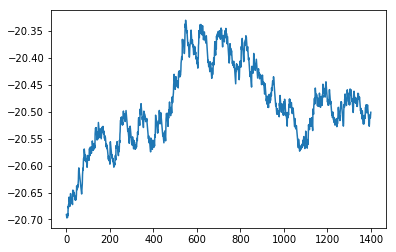

-21.0 -20.5058754421
-21.0 -20.5108166876
-20.0 -20.5057085208
-21.0 -20.5106514356
-20.0 -20.5055449212
-20.0 -20.500489472
-21.0 -20.5054845773
-21.0 -20.5104297315
-20.0 -20.5053254342
-21.0 -20.5102721798
-21.0 -20.515169458
-21.0 -20.5200177635
-20.0 -20.5148175858
-21.0 -20.51966941
-21.0 -20.5244727159
-21.0 -20.5292279887
-21.0 -20.5339357088
-19.0 -20.5185963517
-21.0 -20.5234103882
-21.0 -20.5281762843
-20.5281762843 -21.0
-20.0 -20.5228945215
-20.0 -20.5176655763
-21.0 -20.5224889205
-20.0 -20.5172640313
-21.0 -20.522091391
-20.0 -20.5168704771
-21.0 -20.5217017723
-20.0 -20.5164847546
-18.0 -20.491319907
-21.0 -20.496406708
-21.0 -20.5014426409
-20.0 -20.4964282145
-21.0 -20.5014639323
-21.0 -20.506449293
-20.0 -20.5013848001
-19.0 -20.4863709521
-20.0 -20.4815072426
-21.0 -20.4866921701
-21.0 -20.4918252484
-21.0 -20.496906996
-20.496906996 -21.0
-18.0 -20.471937926
-20.0 -20.4672185467
-21.0 -20.4725463613
-19.0 -20.4578208977
-20.0 -20.4532426887
-21.0 -20.4587102618
-21

In [ ]:
from lib.TRPO import *
import matplotlib.pyplot as plt

env = gym.make("Pong-v0")
#env = wrappers.Monitor(env, '/tmp/acrobot-v1',force=True)
#bazel build -c opt --copt=-mavx --copt=-mavx2 --copt=-mfma --copt=-mfpmath=both --copt=-msse4.2 --config=cuda -k //tensorflow/tools/pip_package:build_pip_package

d = 9*9*3
bins = 2
num_obs = 2
input_shape = (None, num_obs, 80, 80, 1)
layers = ['flatten', 'fc', (None, 256)]
discount = 0.99
T = 5000

#trpo = TRPO(input_shape, layers, num_actions=bins)
#plot_rews = []

#avg_rew = 0
alpha = 0.99
batch_size = 32

def update(actions, states, rewards):
    
    acc_rew = []
    n = len(rewards)
    if n == 0:
        return
    
    acc_rew.append(rewards[-1])
    for i in range(n-1):
        acc_rew = [discount*acc_rew[0] + rewards[n-i-1]] + acc_rew
    
    #for i in range(n):
    #    acc_rew[i] -= acc_rew[i]/(n-i)
    
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions)
    advantages = np.array(acc_rew)
    
    #split_states = np.array_split(states, batch_size)
    #split_actions = np.array_split(actions, batch_size)
    #split_advantages = np.array_split(advantages, batch_size)
    #for st, ac, ad in zip(split_states, split_actions, split_advantages):
    #    trpo.add_trajectory(st, ac, ad)
    
    trpo.add_trajectory(states, actions, advantages)
    
    global avg_rew
    avg_rew = alpha*avg_rew + (1-alpha)*np.sum(rewards)
    
    print(np.sum(rewards), avg_rew)
    
    plot_rews.append(avg_rew)
    
    if len(plot_rews) % 20 == 0:
        print(avg_rew, np.sum(rewards))
    
    if len(plot_rews)%100 == 0:
        plt.clf()
        plt.plot(plot_rews[1500:])
        plt.show()
    
def policy(obs):
    return trpo.choose_action(obs)[0] + 2

play(5000, T, policy, update, preprocess=preprocess_observations, num_obs=num_obs)

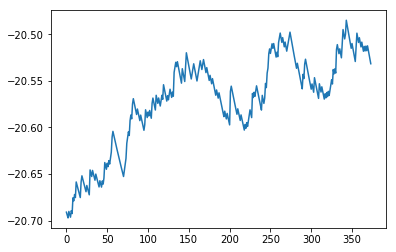

In [35]:
plt.plot(plot_rews[1500:])

[2017-06-03 20:37:54,132] Making new env: Hex9x9-v0


82